In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [2]:
df = pd.read_csv('D:/Data_Science/Datasheet/retail/Retail_Data_Transactions.csv',sep=';',encoding='utf-8', parse_dates=['sale_date'])

In [3]:
df.head()

,customer_id,sale_date,sale_value
0,AA5295,2013-11-02,35
1,AA4768,2015-03-15,39
2,AA2122,2013-02-26,52
3,AA1217,2011-11-16,99
4,AA1850,2013-11-20,78


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   customer_id  125000 non-null  object        
 1   sale_date    125000 non-null  datetime64[ns]
 2   sale_value   125000 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.9+ MB


In [5]:
df.isnull().sum()

customer_id    0
sale_date      0
sale_value     0
dtype: int64

In [6]:
print(df['sale_date'].min(), df['sale_date'].max())

2011-01-06 00:00:00 2015-12-03 00:00:00


Calcular o número de dias de cada venda desde a data posterior a última transção (04/12/2015)

In [7]:
sd = dt.datetime(2015,12,4)
df['hist']=sd - df['sale_date']
df['hist'].astype('timedelta64[D]')
df['hist']=df['hist'] / np.timedelta64(1, 'D')
df.head()

,customer_id,sale_date,sale_value,hist
0,AA5295,2013-11-02,35,762.0
1,AA4768,2015-03-15,39,264.0
2,AA2122,2013-02-26,52,1011.0
3,AA1217,2011-11-16,99,1479.0
4,AA1850,2013-11-20,78,744.0


In [8]:
rfm_df = df.groupby('customer_id').agg({'hist': lambda x:x.min(), # Identify & Define Recency
                                        'customer_id': lambda x: len(x),               # Identify & Define Frequency
                                        'sale_value': lambda x: x.sum()})          # Identify & Define Monetary Value

rfm_df.rename(columns={'hist': 'recency', 
                         'customer_id': 'frequency', 
                         'sale_value': 'monetary_value'}, inplace=True)

In [9]:
rfm_df.head()

,recency,frequency,monetary_value
customer_id,,,
AA1112,324.0,15,1012
AA1113,93.0,20,1490
AA1114,2.0,19,1432
AA1115,215.0,22,1659
AA1116,466.0,13,857


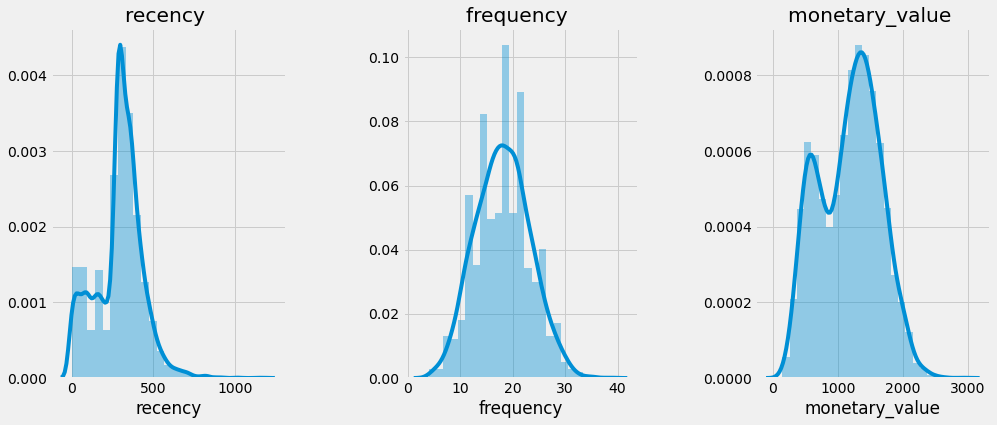

In [10]:
plt.style.use('fivethirtyeight')

plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['recency' , 'frequency' , 'monetary_value']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(rfm_df[x] , bins = 25)
    plt.title('{} '.format(x))
plt.show()

In [11]:
correlation = rfm_df.corr('spearman')
correlation

,recency,frequency,monetary_value
recency,1.000000,-0.248320,-0.238084
frequency,-0.248320,1.000000,0.939974
monetary_value,-0.238084,0.939974,1.000000


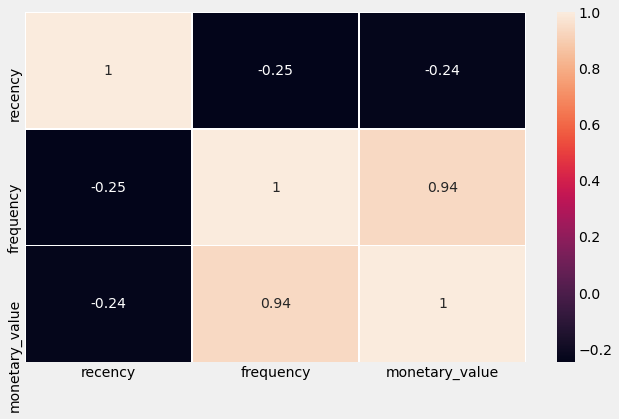

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.heatmap(correlation, annot=True, linewidths= .5, ax=ax)

In [13]:
groups = rfm_df.quantile(q=[0.20,0.40,0.60,0.80])
print(groups, type(groups))

     recency  frequency  monetary_value
0.2    156.0       14.0           681.0
0.4    285.0       17.0          1095.0
0.6    335.0       19.8          1345.0
0.8    393.0       23.0          1589.0 <class 'pandas.core.frame.DataFrame'>


In [14]:
groups=groups.to_dict()
groups

{'recency': {0.2: 156.0, 0.4: 285.0, 0.6: 335.0, 0.8: 393.0},
 'frequency': {0.2: 14.0, 0.4: 17.0, 0.6: 19.800000000000182, 0.8: 23.0},
 'monetary_value': {0.2: 681.0, 0.4: 1095.0, 0.6: 1345.0, 0.8: 1589.0}}

In [15]:
def rclass(x,p,d):
    if x <= d[p][0.20]:
        return 5
    elif x <= d[p][0.40]:
        return 4
    elif x <= d[p][0.60]:
        return 3
    elif x <= d[p][0.80]:
        return 2
    else:
        return 1
    
def fmclass(x,p,d):
    if x <= d[p][0.20]:
        return 1
    elif x <= d[p][0.40]:
        return 2
    elif x <= d[p][0.60]:
        return 3
    elif x <= d[p][0.80]:
        return 4
    else:
        return 5

In [16]:
rfm_df_seg = rfm_df
rfm_df_seg['R_Class'] = rfm_df_seg['recency'].apply(rclass, args=('recency',groups,))
rfm_df_seg['F_Class'] = rfm_df_seg['frequency'].apply(fmclass, args=('frequency',groups,))
rfm_df_seg['M_Class'] = rfm_df_seg['monetary_value'].apply(fmclass, args=('monetary_value',groups,))

In [17]:
rfm_df_seg.head()

,recency,frequency,monetary_value,R_Class,F_Class,M_Class
customer_id,,,,,,
AA1112,324.0,15,1012,3,2,2
AA1113,93.0,20,1490,5,4,4
AA1114,2.0,19,1432,5,3,4
AA1115,215.0,22,1659,4,4,5
AA1116,466.0,13,857,1,1,2


In [18]:
rfm_df_seg['RFM Class'] = round((rfm_df_seg['R_Class'] + rfm_df_seg['F_Class'] + rfm_df_seg['M_Class'])/3,2)

In [19]:
rfm_df_seg.head()

,recency,frequency,monetary_value,R_Class,F_Class,M_Class,RFM Class
customer_id,,,,,,,
AA1112,324.0,15,1012,3,2,2,2.33
AA1113,93.0,20,1490,5,4,4,4.33
AA1114,2.0,19,1432,5,3,4,4.00
AA1115,215.0,22,1659,4,4,5,4.33
AA1116,466.0,13,857,1,1,2,1.33


In [20]:
rfm_df_seg.groupby('RFM Class').agg('monetary_value').mean().sort_values(ascending=False).round(2)

RFM Class
5.00    1878.45
4.67    1791.78
4.33    1637.64
4.00    1595.49
3.67    1465.16
3.33    1335.92
3.00    1213.46
2.67    1079.93
2.33     903.84
2.00     811.76
1.67     704.03
1.33     644.79
1.00     472.82
Name: monetary_value, dtype: float64

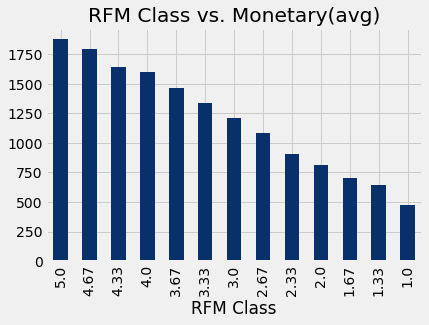

In [24]:
rfm_df_seg.groupby('RFM Class').agg('monetary_value').mean().sort_values(ascending=False).plot(kind='bar', title="RFM Class vs. Monetary(avg)", colormap='Blues_r')

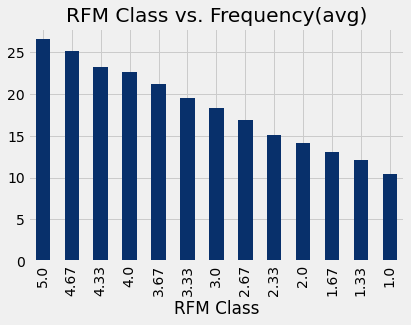

In [23]:
rfm_df_seg.groupby('RFM Class').agg('frequency').mean().sort_values(ascending=False).plot(kind='bar', title="RFM Class vs. Frequency(avg)", colormap='Blues_r')

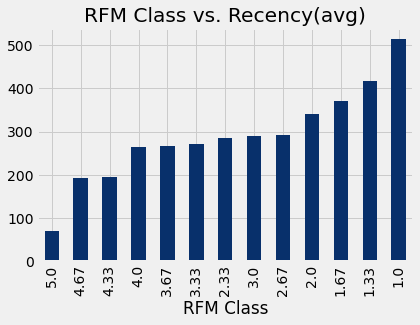

In [25]:
rfm_df_seg.groupby('RFM Class').agg('recency').mean().sort_values(ascending=True).plot(kind='bar', title="RFM Class vs. Recency(avg)", colormap='Blues_r')
